Quantization Error: 4.180329230191474


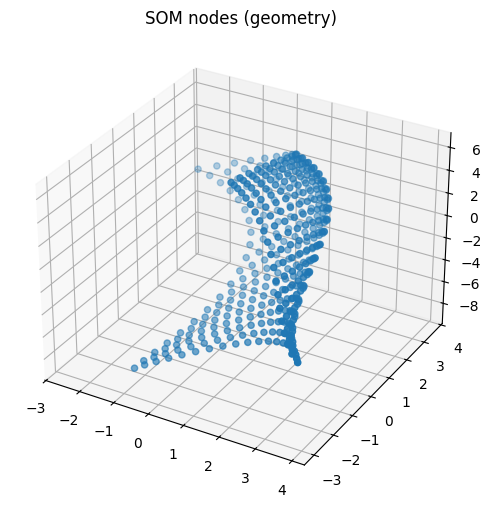

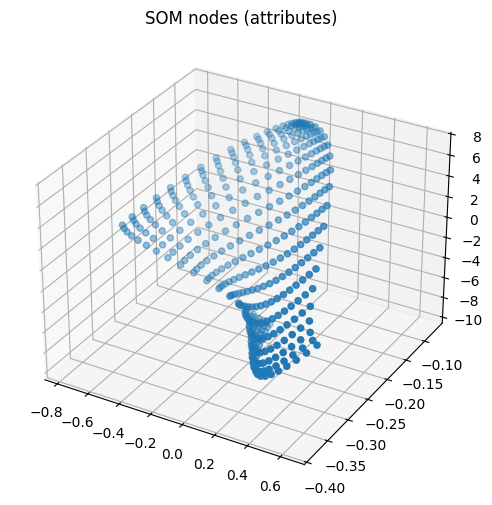

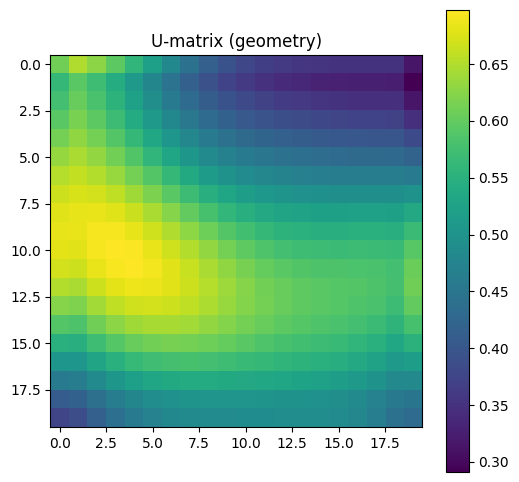

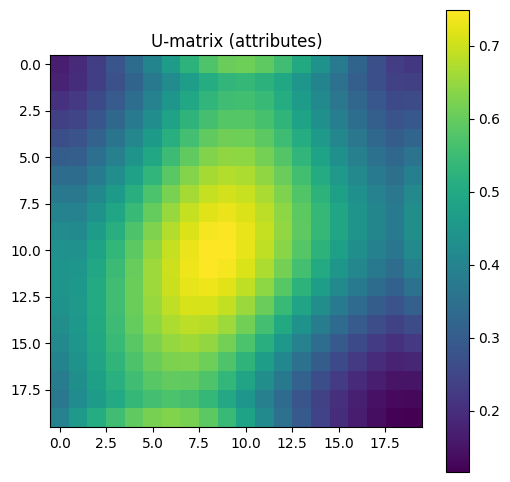

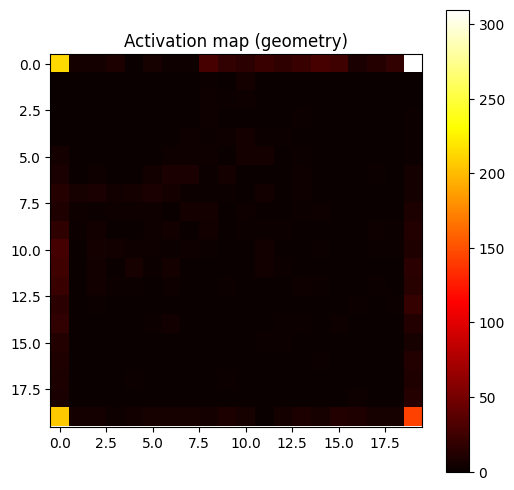

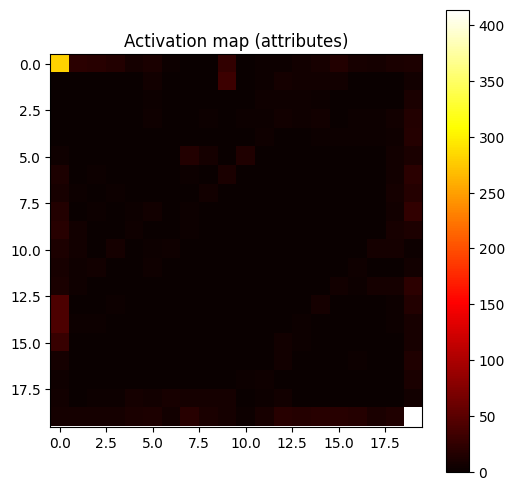

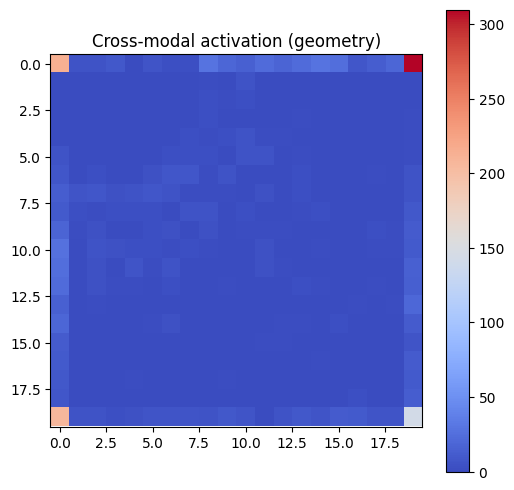

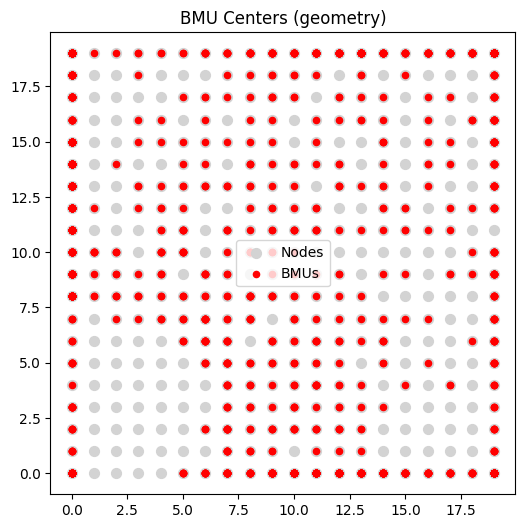

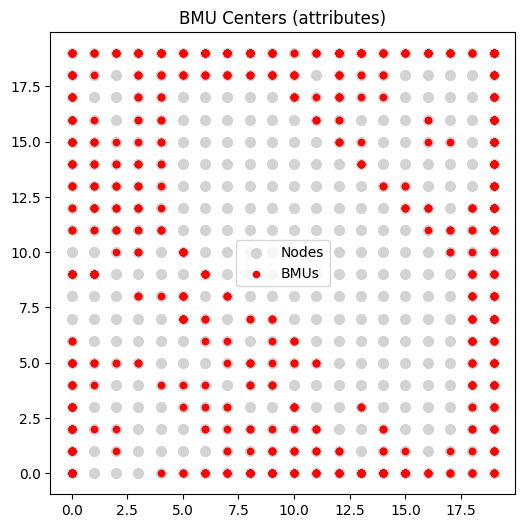

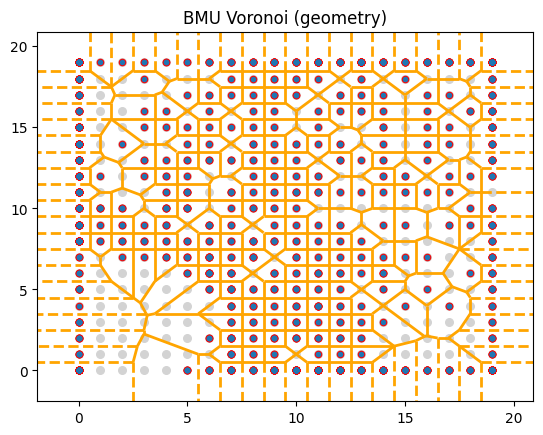

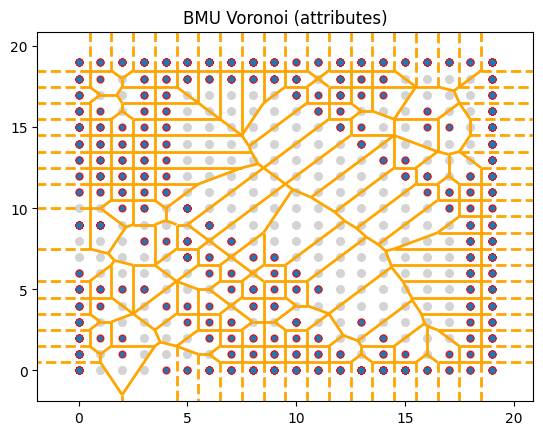

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from scipy.spatial import Voronoi, voronoi_plot_2d

# ======================================================
# ASSOCIATIVE SELF-ORGANIZING MAP (A-SOM)
# ======================================================

class ASOM:
    def __init__(self, modalities, N=20, init="random", seed=None):
        if seed is not None:
            np.random.seed(seed)

        self.modalities = {k: np.asarray(v) for k, v in modalities.items()}
        self.mod_names = list(self.modalities.keys())
        self.N = N
        self.map_nodes = N * N

        # Shared 2D grid coordinates
        x, y = np.meshgrid(range(N), range(N))
        self.c = np.vstack([y.flatten(), x.flatten()]).T  # shape: (N*N, 2)

        # SOM weight matrices
        self.som_weights = {m: self._init_som(v, init) for m, v in self.modalities.items()}

        # Hebbian association matrices
        self.assoc = {}
        for i in range(len(self.mod_names)):
            for j in range(i + 1, len(self.mod_names)):
                a, b = self.mod_names[i], self.mod_names[j]
                self.assoc[(a, b)] = np.zeros((self.map_nodes, self.map_nodes))

    def _init_som(self, data, init):
        if init == "random":
            return np.random.rand(self.map_nodes, data.shape[1])
        else:
            raise ValueError("init must be 'random'")

    def _find_bmu(self, weights, vector):
        return np.argmin(np.linalg.norm(weights - vector, axis=1))

    def train(self, epochs=5000, alpha_init=0.5):
        T = epochs
        n = len(next(iter(self.modalities.values())))
        alpha = alpha_init
        for t in range(epochs):
            # alpha = alpha_init * np.exp(-t / T)
            alpha = max(alpha * .9999, 0.01)   #not optimal writing pattern, but easy to think about
            sigma = self.N * np.exp(-t / T)

            i = np.random.randint(n)
            bmus = {}
            for m in self.mod_names:
                sample = self.modalities[m][i]
                bmus[m] = self._find_bmu(self.som_weights[m], sample)

            for m in self.mod_names:
                sample = self.modalities[m][i]
                w = self.som_weights[m]
                d = np.linalg.norm(self.c - self.c[bmus[m]], axis=1)
                h = np.exp(-(d**2) / (2 * sigma**2))
                self.som_weights[m] += alpha * h[:, None] * (sample - w)

            for (a, b), matrix in self.assoc.items():
                matrix[bmus[a], bmus[b]] += 1

        # Normalize associations
        for key in self.assoc:
            self.assoc[key] /= np.max(self.assoc[key])

    # ======================================================
    # Metrics
    # ======================================================

    def quantization_error(self):
        errs = []
        n = len(next(iter(self.modalities.values())))
        for i in range(n):
            for m in self.mod_names:
                sample = self.modalities[m][i]
                bmu = self._find_bmu(self.som_weights[m], sample)
                errs.append(np.linalg.norm(sample - self.som_weights[m][bmu]))
        return np.mean(errs)

    # ======================================================
    # Cross-modal generation
    # ======================================================

    def generate_cross(self, stim_mod, stim_vector):
        bmu_idx = self._find_bmu(self.som_weights[stim_mod], stim_vector)
        preds = {}
        for (a, b), matrix in self.assoc.items():
            if a == stim_mod:
                preds[b] = np.argmax(matrix[bmu_idx, :])
            elif b == stim_mod:
                preds[a] = np.argmax(matrix[:, bmu_idx])
        return preds

    # ======================================================
    # Visualizations
    # ======================================================

    # SOM nodes in 3D
    def plot_som_3d(self, modality):
        W = self.som_weights[modality]
        fig = plt.figure(figsize=(7,6))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(W[:,0], W[:,1], W[:,2], s=20)
        ax.set_title(f"SOM nodes ({modality})")
        plt.show()

    # U-matrix
    def plot_umatrix(self, modality):
        W = self.som_weights[modality].reshape(self.N, self.N, -1)
        umat = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                neighbors = []
                if i > 0: neighbors.append(W[i-1, j])
                if i < self.N-1: neighbors.append(W[i+1, j])
                if j > 0: neighbors.append(W[i, j-1])
                if j < self.N-1: neighbors.append(W[i, j+1])
                umat[i,j] = np.mean([np.linalg.norm(W[i,j]-n) for n in neighbors])
        plt.figure(figsize=(6,6))
        plt.imshow(umat, cmap='viridis')
        plt.colorbar()
        plt.title(f"U-matrix ({modality})")
        plt.show()

    # Activation / Hit map
    def plot_activation_map(self, modality):
        hits = np.zeros(self.map_nodes)
        for x in self.modalities[modality]:
            hits[self._find_bmu(self.som_weights[modality], x)] += 1
        hits = hits.reshape(self.N, self.N)
        plt.figure(figsize=(6,6))
        plt.imshow(hits, cmap='hot')
        plt.colorbar()
        plt.title(f"Activation map ({modality})")
        plt.show()

    # Cross-modal activation
    def plot_cross_activation(self, stim_mod):
        hits = np.zeros(self.map_nodes)
        n = len(self.modalities[stim_mod])
        for i in range(n):
            sample = {m: self.modalities[m][i] for m in self.mod_names}
            bmu_idx = self._find_bmu(self.som_weights[stim_mod], sample[stim_mod])
            hits[bmu_idx] += 1
        hits = hits.reshape(self.N, self.N)
        plt.figure(figsize=(6,6))
        plt.imshow(hits, cmap='coolwarm')
        plt.colorbar()
        plt.title(f"Cross-modal activation ({stim_mod})")
        plt.show()

    # BMU centers (like in the paper)
    def plot_bmu_centers(self, modality):
        centers = np.array([self._find_bmu(self.som_weights[modality], x) for x in self.modalities[modality]])
        plt.figure(figsize=(6,6))
        plt.scatter(self.c[:,0], self.c[:,1], c='lightgray', s=50, label='Nodes')
        plt.scatter(self.c[centers,0], self.c[centers,1], c='red', s=20, label='BMUs')
        plt.title(f'BMU Centers ({modality})')
        plt.legend()
        plt.show()

    # Voronoi diagram for BMU coverage
    def plot_bmu_voronoi(self, modality):
        centers = np.array([self._find_bmu(self.som_weights[modality], x) for x in self.modalities[modality]])
        points = self.c[centers]
        if len(points) > 0:
            vor = Voronoi(points)
            fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=2)
            plt.scatter(self.c[:,0], self.c[:,1], c='lightgray', s=30)
            plt.scatter(points[:,0], points[:,1], c='red', s=20)
            plt.title(f'BMU Voronoi ({modality})')
            plt.show()


# ======================================================
# DEMO DATA (2 MODALITIES)
# ======================================================

X1, _ = make_swiss_roll(n_samples=2000)
X1 -= X1.mean(axis=0)
X2 = np.column_stack([np.sin(X1[:,0]), np.cos(X1[:,1]), X1[:,2]])

modalities = {
    "geometry": X1,
    "attributes": X2
}

# ======================================================
# TRAIN
# ======================================================

msom = ASOM(modalities, N=20, init="random", seed=42)
msom.train(epochs=3000)
print("Quantization Error:", msom.quantization_error())

# ======================================================
# FIGURES
# ======================================================

# 3D SOM nodes
msom.plot_som_3d("geometry")
msom.plot_som_3d("attributes")

# U-matrices
msom.plot_umatrix("geometry")
msom.plot_umatrix("attributes")

# Activation / hit maps
msom.plot_activation_map("geometry")
msom.plot_activation_map("attributes")

# Cross-modal activation heatmaps
msom.plot_cross_activation("geometry")

# BMU center plots (matching paper)
msom.plot_bmu_centers("geometry")
msom.plot_bmu_centers("attributes")

# Optional Voronoi plots
msom.plot_bmu_voronoi("geometry")
msom.plot_bmu_voronoi("attributes")